In [1]:
import numpy as np
import matplotlib.pyplot as plt
import optimize
import workload
import pickle

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [5]:
n = 256
A = optimize.restart_optimize(workload.AllRange(n), 50, 16)
#A = np.load('/home/ryan/Desktop/strategies/all-range-%d.npy' % n)
B = A[n:]
B = B[(B>0).sum(axis=1)>1]
idx = np.argsort(B.argmax(axis=1))
B = B[idx]

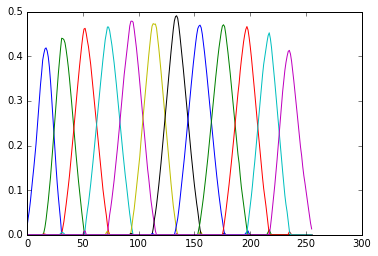

In [6]:
plt.plot(B.T)
plt.show()

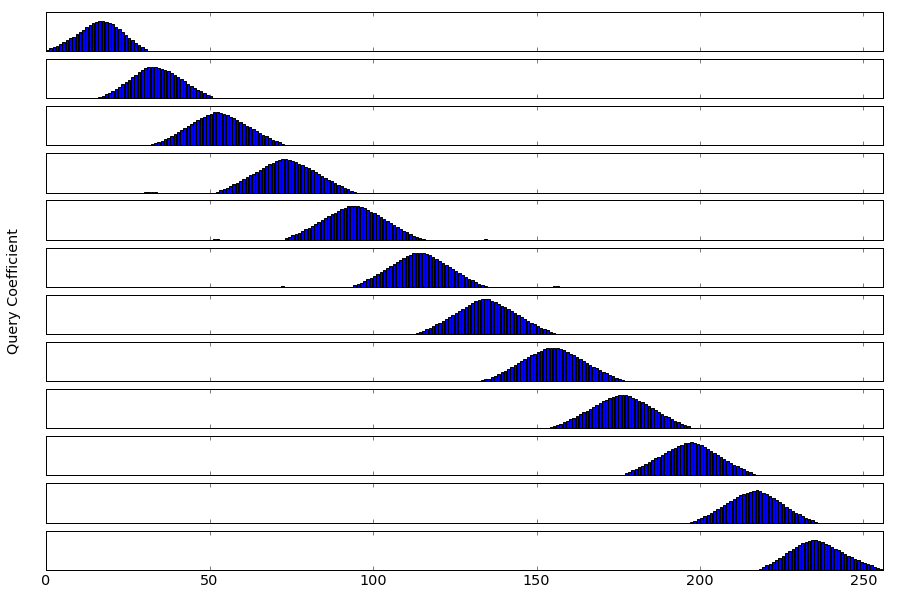

In [13]:
x = np.arange(B.shape[1])
k = B.shape[0]
fig, axs = plt.subplots(nrows=k, sharex=True, sharey=True, figsize=(15, 10))
for i in range(k):
    axs[i].bar(x, B[i])
    axs[i].set_ylim(0,0.55)
    axs[i].get_yaxis().set_visible(False)
plt.xlim(0,n)
plt.xticks(fontsize='x-large')
fig.add_subplot(111, frameon=False).set_ylabel('Query Coefficient', fontsize='x-large')
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.savefig('plot1.pdf')
plt.show()

In [ ]:
n = 256
W = workload.AllRange(n)
errors = np.zeros(100)
for i in range(errors.size):
    B0 = np.random.rand(n//16, n)
    ans = optimize.augmented_optimization(W.WtW,B0)
    errors[i] = ans['res'].fun
errors = np.sqrt(errors/errors.min())
np.save('range256-distribution.npy', errors)

In [2]:
errors = np.load('range256-distribution.npy')
plt.hist(errors,bins=10)
plt.title('Range Queries Workload')
plt.xlabel('Relative Error')
plt.ylabel('Count')
plt.savefig('range256dist.pdf')
plt.show()

IOError: [Errno 2] No such file or directory: 'range256-distribution.npy'

In [ ]:
W = workload.LowDimMarginals([10]*8, 4)
errors = np.zeros(100)
for i in range(errors.size):
    ans = optimize.datacubes_optimization(W)
    errors[i] = ans['res'].fun
errors = np.sqrt(errors/errors.min())
np.save('marginals-distribution.npy', errors)

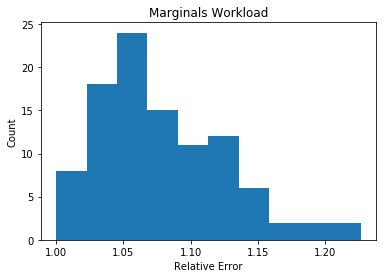

In [4]:
errors = np.load('marginals-distribution.npy')
plt.hist(errors,bins=10)
plt.title('Marginals Workload')
plt.xlabel('Relative Error')
plt.ylabel('Count')
plt.savefig('marginalsdist.pdf')
plt.show()

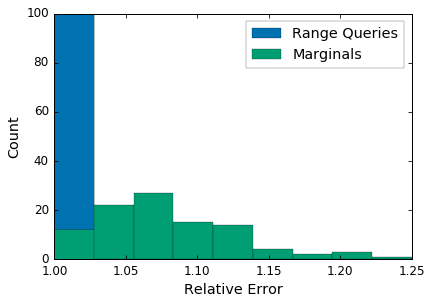

In [31]:
from scipy.stats import gaussian_kde
plt.style.use('seaborn-paper')
errors1 = np.load('../experiments/results/range256-distribution.npy')
errors2 = np.load('../experiments/results/marginals-distribution.npy')
bins = np.linspace(1.0, 1.25, 10)
plt.hist(errors1, bins=bins, label='Range Queries')
plt.hist(errors2, bins=bins, label='Marginals')
plt.xlim(1.0, 1.25)
plt.legend(loc='upper right', fontsize='x-large')
plt.xlabel('Relative Error', fontsize='x-large')
plt.ylabel('Count', fontsize='x-large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.savefig('errordist.pdf')
plt.show()

In [48]:
W = workload.Range2D(64)
W1 = workload.AllRange(64)

A1 = optimize.restart_optimize(W1, 100, 64//8)

B0 = np.random.rand(4096//16, 4096)
ans = optimize.augmented_optimization(W.WtW, B0)

278.907387018


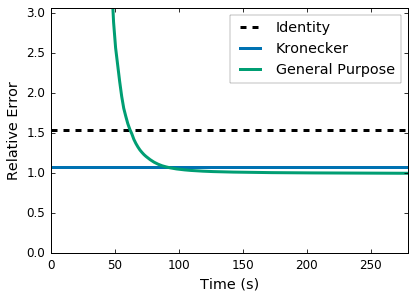

In [52]:
print ans['time']
eye = W.expected_error([np.eye(64), np.eye(64)])
kron = W.expected_error([A1, A1])

log = ans['log']

best = log[-1]
eye = np.sqrt(eye / best)
kron = np.sqrt(kron / best)
log = np.sqrt(log / best)

time = ans['time']
times = np.linspace(0, time, len(log))
plt.style.use('seaborn-paper')
plt.plot([0,time], [eye,eye], 'k--', linewidth=3, label='Identity')
plt.plot([0,time], [kron,kron], linewidth=3, label='Kronecker')
plt.plot(times, log, linewidth=3, label='General Purpose')
plt.xlim(0, time)
plt.ylim(0,2*eye)
plt.xlabel('Time (s)', fontsize='x-large')
plt.ylabel('Relative Error', fontsize='x-large')
plt.legend(loc='upper right', fontsize='x-large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.savefig('quality_vs_time.pdf')
plt.show()


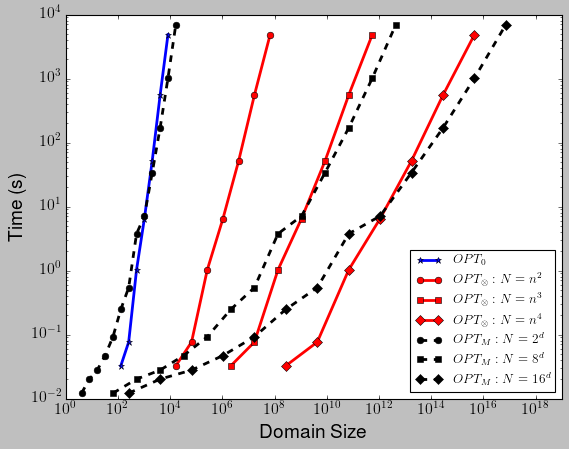

In [73]:
import pandas as pd
gp = pd.read_csv('../experiments/results/togus_scalability.csv')
marg = pd.read_csv('../experiments/results/togus_scalability_marginals_uniform.csv')
marg = marg.groupby('dims').time.mean()[:-1]

plt.style.use('classic')
plt.rc('text', usetex=True)
w = 2.5
plt.plot(gp.domain, gp.time, 'b*-', markersize=6, linewidth=w, label='$OPT_0$')
plt.plot(gp.domain**2, gp.time, 'ro-',markersize=6,linewidth=w, label='$OPT_{\otimes}: N = n^2$')
plt.plot(gp.domain**3, gp.time, 'rs-', markersize=6,linewidth=w, label='$OPT_{\otimes}: N = n^3$')
plt.plot(gp.domain**4, gp.time, 'rD-', markersize=6,linewidth=w, label='$OPT_{\otimes}: N = n^4$')
plt.plot(2**marg.index, marg.values, 'ko--', markersize=6,linewidth=w, label='$OPT_M: N = 2^d$')
plt.plot(8**marg.index, marg.values, 'ks--', markersize=6,linewidth=w, label='$OPT_M: N = 8^d$')
plt.plot(16**marg.index, marg.values, 'kD--', markersize=6,linewidth=w, label='$OPT_M: N = 16^d$')

plt.legend(loc='lower right', fontsize='medium')
plt.xlim(1, 10**19)
plt.xlabel('Domain Size', fontsize='x-large')
plt.ylabel('Time (s)', fontsize='x-large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.loglog()
plt.savefig('togus_scalability_optimization.pdf')
plt.show()

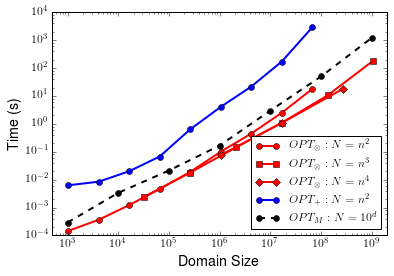

In [6]:
import pickle
time2d, time3d, time4d, timesum, timedc = pickle.load(open('../experiments/results/scalability_running.pkl', 'rb'))
dom2d = np.array([16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192])
dom3d = np.array([16, 32, 64, 128, 256, 512, 1024])
dom4d = np.array([16, 32, 64, 128])

dom2d = dom2d[1:]
dom3d = dom3d[1:]
dom4d = dom4d[1:]
domdc = np.arange(2, 10)

w = 2.0
plt.rc('text', usetex=True)
plt.plot(dom2d**2, time2d, 'ro-', markersize=6, linewidth=w,label='$OPT_{\otimes}: N = n^2$')
plt.plot(dom3d**3, time3d, 'rs-', markersize=6, linewidth=w,label='$OPT_{\otimes}: N = n^3$')
plt.plot(dom4d**4, time4d, 'rD-', markersize=6, linewidth=w,label='$OPT_{\otimes}: N = n^4$')
plt.plot(dom2d**2, timesum, 'bo-', markersize=6, linewidth=w,label='$OPT_+: N = n^2$')
plt.plot(10**domdc[1:], timedc[1:], 'ko--', markersize=6, linewidth=w,label='$OPT_M: N = 10^d$')
plt.loglog()
plt.legend(loc='lower right')
plt.xlim(10**3/2,10**9*2)
plt.xlabel('Domain Size', fontsize='x-large')
plt.ylabel('Time (s)', fontsize='x-large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.savefig('scalability_mechanism.png')
plt.savefig('scalability_mechanism.pdf')
plt.show()

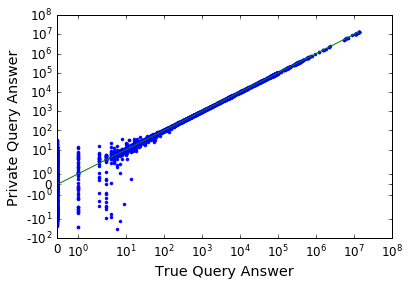

In [3]:
results = pickle.load(open('../experiments/results/relative_error.pkl', 'rb'))
ans, err = results[(False, 1.0)]
ref = np.arange(ans.max())

plt.plot(ans, ans+err, '.')
plt.plot(ref, ref)
plt.xscale('symlog')
plt.yscale('symlog')
plt.xlabel('True Query Answer', fontsize='x-large')
plt.ylabel('Private Query Answer', fontsize='x-large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.savefig('relative_error_sf1_1.0.pdf')
plt.show()

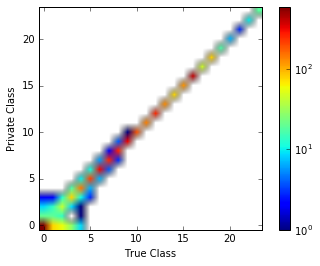

In [5]:
from matplotlib.colors import LogNorm
buckets = np.floor(np.log2(np.maximum(ans,1))).astype(int)
private = np.floor(np.log2(np.maximum(ans+err,1))).astype(int)
b = np.max(buckets) + 1
H = np.zeros((b,b))
np.add.at(H, (buckets, private), 1)
plt.imshow(H, norm=LogNorm(), origin='lower')
plt.xlabel('True Class')
plt.ylabel('Private Class')
plt.colorbar()
plt.savefig('relative_error2_sf1_1.0.pdf')
plt.show()

In [2]:
print 'geo, eps, b, num, median, 95%'
results = pickle.load(open('../experiments/results/relative_error.pkl', 'rb'))
ans, err = results[(False, 1.0)]

for geo in [False, True]:
    for eps in [0.1, 1.0]:
        ans, err = results[(geo, eps)]
        buckets = np.floor(np.log10(np.maximum(ans,1))).astype(int)
        for b in range(np.max(buckets)+1):
            idx = (buckets == b)
            rel = np.abs(err[idx]) / np.maximum(ans[idx], 1)
            tmp = np.abs(err[idx])
            print ','.join(map(str, [eps, geo, 10**(b+1), idx.sum(), np.median(tmp), np.percentile(tmp, 95), np.median(rel), np.percentile(rel, 95)]))

geo, eps, b, num, median, 95%
0.1,False,10,943,17.2788302825,88.6272141547,13.2012259427,85.8969638476
0.1,False,100,684,17.1136018129,127.055026741,0.381727201646,3.49554757925
0.1,False,1000,1000,19.6681135358,91.6412241139,0.0584300156816,0.380622389683
0.1,False,10000,614,24.433294088,124.037045108,0.00692373349243,0.0640219233691
0.1,False,100000,689,48.4056088961,180.608638637,0.000897722526175,0.0049619434517
0.1,False,1000000,159,96.7927044753,356.005852586,0.000399770682889,0.00124289112215
0.1,False,10000000,21,88.2203617834,356.268833778,2.98983079968e-05,0.000183027339163
0.1,False,100000000,18,81.3515042947,155.214904571,7.75448212644e-06,1.40624316149e-05
1.0,False,10,943,1.71819207915,11.1266900659,1.426259174,9.70195830556
1.0,False,100,684,1.71181442573,9.12030600906,0.0420185240625,0.326308100461
1.0,False,1000,1000,1.97693628685,9.49830300453,0.00622770045961,0.0389042958701
1.0,False,10000,614,2.53224003506,11.3615896714,0.000752630340368,0.005430733841
1.0,False,10

In [2]:
print 'eps, geo, num(<100), num(100-1000), num(>=1000), rel(<100), rel(100-1000), rel(>=1000)'
results = pickle.load(open('../experiments/results/relative_error.pkl', 'rb'))
ans, err = results[(False, 1.0)]

for geo in [False, True]:
    for eps in [0.1, 1.0]:
        delta = 1.0 / eps
        ans, err = results[(geo, eps)]
        idx1 = ans < 100
        rel1 = np.abs(err[idx1]) / np.maximum(ans[idx1], delta)
        idx2 = (ans >= 100) & (ans < 1000)
        rel2 = np.abs(err[idx2]) / np.maximum(ans[idx2], delta)
        idx3 = ans >= 1000
        rel3 = np.abs(err[idx3]) / np.maximum(ans[idx3], delta)
        
        print ','.join(map(str, [eps, geo, idx1.sum(), idx2.sum(), idx3.sum(), np.median(rel1), np.median(rel2), np.median(rel3)]))

eps, geo, num(<100), num(100-1000), num(>=1000), rel(<100), rel(100-1000), rel(>=1000)
0.1,False,1627,1000,1524,0.994312429691,0.0604343348107,0.0014154113372
1.0,False,1627,1000,1524,0.33265429184,0.00601945596644,0.000145821807585
0.1,True,166724,24934,24194,1.97310486576,0.158178965277,0.0221643256574
1.0,True,166724,24934,24194,1.36794689578,0.0155918057393,0.00220178962571
